In [1]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import random
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import cross_val_predict

from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
import warnings
# from sklearn.linear_model import LinearRegression

matplotlib.style.use('ggplot')
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
np.random.seed(17)
random.seed(17)

# print(len(train),len(properties),len(submission))

def get_features(df):
    df["transactiondate_date"] = pd.to_datetime(df["transactiondate"])
    df["transactiondate_year"] = df["transactiondate"].dt.year
    df["transactiondate_month"] = df["transactiondate"].dt.month
    df['transactiondate_quarter'] = df['transactiondate'].dt.quarter
    return df

def RMSE(y, ypred):
    #logerror=log(Zestimate)−log(SalePrice)
    return np.sqrt(np.sum([(y[i]-ypred[i])*(y[i]-ypred[i]) for i in range(len(y))]) / len(y))

def get_dummy(df):
    for col in dum_var:
        df = pd.merge(pd.get_dummies(df[col]),df,left_index=True, right_index=True)
    return df

    
df = pd.read_csv("ols.csv", parse_dates=['transactiondate'])
df = get_features(df)


In [3]:
dum_var = [df.columns[c] for c in range(len(df.columns)) if df.dtypes[c] == 'O']
dum_var = [i for i in dum_var if i not in ['propertyzoningdesc', 'transactiondate']]
                      
df = get_dummy(df)

exc = [df.columns[c] for c in range(len(df.columns)) if df.dtypes[c] == 'O']+['logerror','parcelid', 'transactiondate','transactiondate_date','transactiondate_year']
col = [c for c in df.columns if c not in exc]

X = df[col]
y = df['logerror'].values

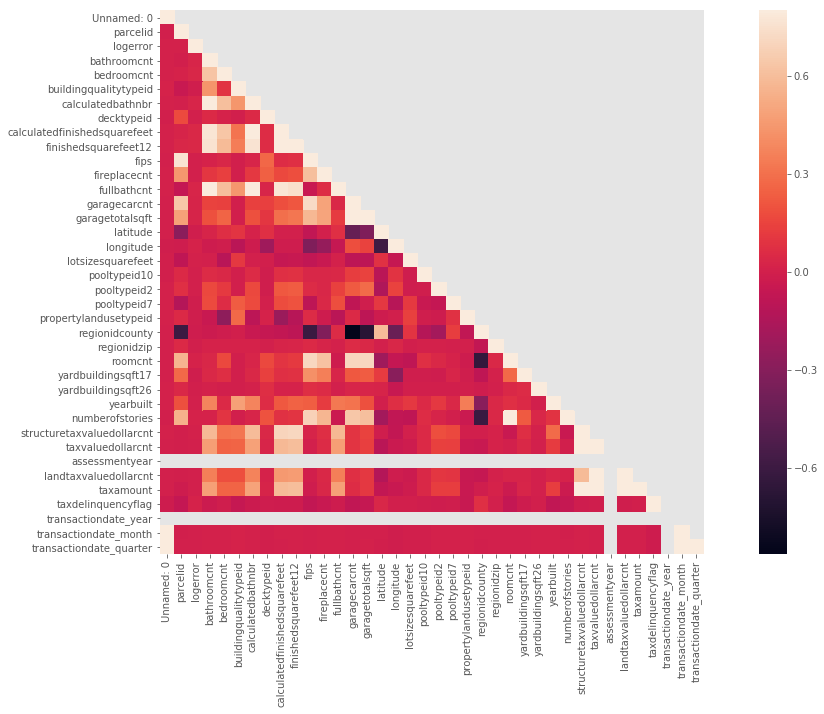

In [21]:
corrMatt = df.corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True)

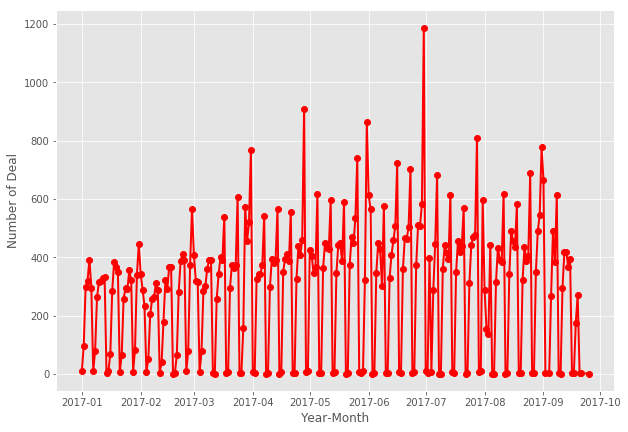

In [132]:
fig = plt.figure(figsize=(10,7))
plt.plot(df.groupby('transactiondate').parcelid.count(), 'ro-', linewidth=2)
# plt.title('Scree Plot')
plt.xlabel('Year-Month')
plt.ylabel('Number of Deal')
# leg = plt.legend([''], loc='best', borderpad=0.3, 
#                  shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
#                  markerscale=0.4)
leg.get_frame().set_alpha(0.4)
leg.draggable(state=True)
plt.show()
fig.savefig('time_series.png')

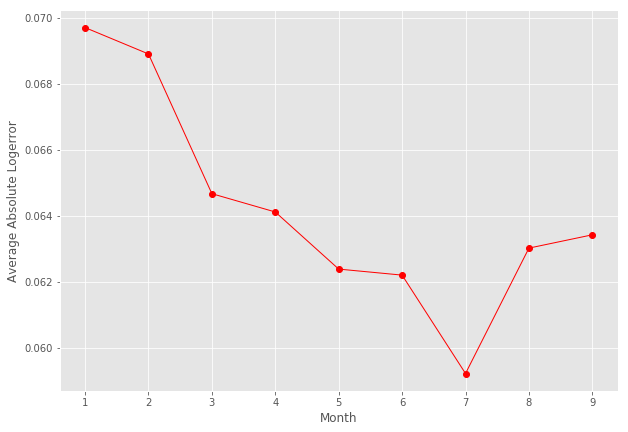

In [12]:
fig = plt.figure(figsize=(10,7))
plt.plot(df_no_outlier.groupby('transactiondate_month').abs_log.mean(), 'ro-', linewidth=1)
# plt.title('Scree Plot')
plt.xlabel('Month')
plt.ylabel('Average Absolute Logerror')
# leg = plt.legend([''], loc='best', borderpad=0.3, 
#                  shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
#                  markerscale=0.4)
plt.show()
fig.savefig('time_series2.png')

In [9]:
df_no_outlier = df[(df['logerror']<1.4) & (df['logerror']>-1.4)]

In [10]:
df_no_outlier['abs_log'] = np.abs(df_no_outlier['logerror'])

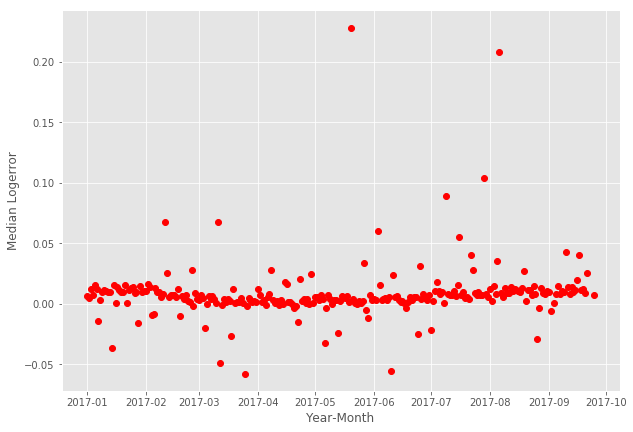

In [163]:
fig = plt.figure(figsize=(10,7))
plt.plot(df_no_outlier.groupby('transactiondate').logerror.median(), 'ro-', linewidth=0)
# plt.title('Scree Plot')
plt.xlabel('Year-Month')
plt.ylabel('Median Logerror')
# leg = plt.legend([''], loc='best', borderpad=0.3, 
#                  shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
#                  markerscale=0.4)
leg.get_frame().set_alpha(0.4)
leg.draggable(state=True)
plt.show()
fig.savefig('time_series3.png')

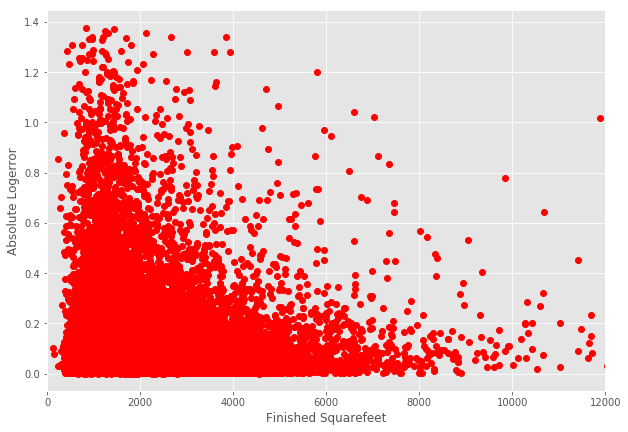

In [33]:

fig = plt.figure(figsize=(10,7))
plt.plot(df_no_outlier.calculatedfinishedsquarefeet, np.abs(df_no_outlier.logerror), 'ro-', linewidth=0)
# plt.title('Scree Plot
plt.xlim(0, 12000)
plt.xlabel('Finished Squarefeet')
plt.ylabel('Absolute Logerror')
# leg = plt.legend([''], loc='best', borderpad=0.3, 
#                  shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
#                  markerscale=0.4)

plt.show()
fig.savefig('finished_square.png')

In [4]:
# def get_pca(df):
from sklearn.decomposition import PCA
pca = PCA(random_state=1)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=1,
  svd_solver='auto', tol=0.0, whiten=False)

In [5]:
X_pca = pca.transform(X)

## PCA Components

In [2]:
# implementing PCA

from sklearn.decomposition import PCA

pca = PCA(n_components=6).fit(X)
pca_samples = pca.transform(X)

def pca_results(X, pca):
    
    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = X.keys())######## 
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1) 
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance']) 
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar')
    ax.set_ylabel("Feature Weights") 
    ax.set_xticklabels(dimensions, rotation=0)

    # Display the explained variance ratios# 
    for i, ev in enumerate(pca.explained_variance_ratio_): 
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

pca_results = pca_results(X, pca)

## Biplot

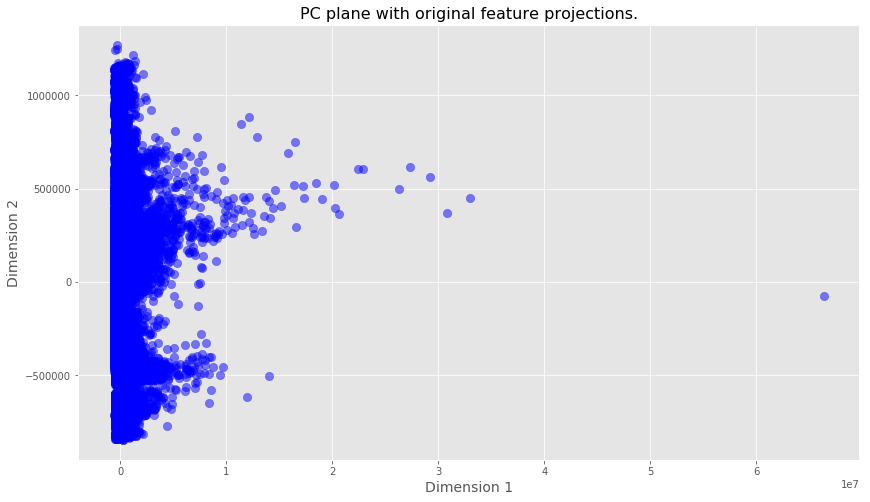

In [12]:
# creating a biplot

pca = PCA(n_components=2).fit(X)
reduced_data = pca.transform(X)
pca_samples = pca.transform(X)
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])



def biplot(X, reduced_data, pca):
    
    fig, ax = plt.subplots(figsize = (14,8))
    
    # scatterplot of the reduced data 
    ax.scatter(x=reduced_data.loc[:, 'Dimension 1'], y=reduced_data.loc[:, 'Dimension 2'], facecolors='b', edgecolors='b', s=70, alpha=0.5)
    
    feature_vectors = pca.components_.T

    # using scaling factors to make the arrows
    arrow_size, text_pos = 7.0, 8.0,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], head_width=0.2, head_length=0.2, linewidth=2, color='red')
        

    ax.set_xlabel("Dimension 1", fontsize=14)
    ax.set_ylabel("Dimension 2", fontsize=14)
    ax.set_title("PC plane with original feature projections.", fontsize=16);
    return ax

biplot(X, reduced_data, pca)

In [1]:
## project data into PC space

# 0,1 denote PC1 and PC2; change values for other PCs
xvector = pca.components_[0] # see 'prcomp(my_data)$rotation' in R
yvector = pca.components_[1]

xs = X_pca[:,0] # see 'prcomp(my_data)$x' in R
ys = X_pca[:,1]

## visualize projections
    
## Note: scale values for arrows and text are a bit inelegant as of now,
##       so feel free to play around with them

for i in range(10):
# arrows project features (ie columns from csv) as vectors onto PC axes
    plt.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys),
              color='r', width=0.0005, head_width=0.0025)
    plt.text(xvector[i]*max(xs)*1.2, yvector[i]*max(ys)*1.2,
             list(X.columns.values)[i], color='r')

for i in range(len(xs)):
# circles project documents (ie rows from csv) as points onto PC axes
    plt.plot(xs[i], ys[i], 'bo')
    plt.text(xs[i]*1.2, ys[i]*1.2, list(X.index)[i], color='b')

plt.show()

In [99]:
X_pca.shape

(77168, 793)

In [6]:
X_pca[:,:5]

array([[  632004.47313696,  -462356.82957287,   -60893.23898374,
         -258496.76583801,   -14178.50516985],
       [    1174.52887618,  1141704.04522825,   261906.41247545,
           23506.06136104,   -31290.04402474],
       [  143448.51075582,  -395959.6471405 ,    24231.78726828,
          176098.57045147,   -12260.94433982],
       ..., 
       [ -528230.04673128,   573388.10932266,    67352.34801553,
           29010.08847479,   -29637.82659666],
       [ -544026.9955559 ,  -132575.11369613,   -38568.34774182,
           95772.81325837,   -26144.46583619],
       [   65042.06411733,  -217110.51170936,     8162.98428795,
           82839.96432416,   -18777.06360426]])

In [107]:
error = []
for i in range(1,200):
    pca = X_pca[:,:i]
    trainX, testX, trainy, testy = train_test_split(pca, y, test_size=0.2, random_state = 1)

    reg = LinearRegression(n_jobs=-1)
    reg.fit(trainX, trainy)
    predy = reg.predict(testX)
    er = RMSE(testy, predy)
    error.append(er)

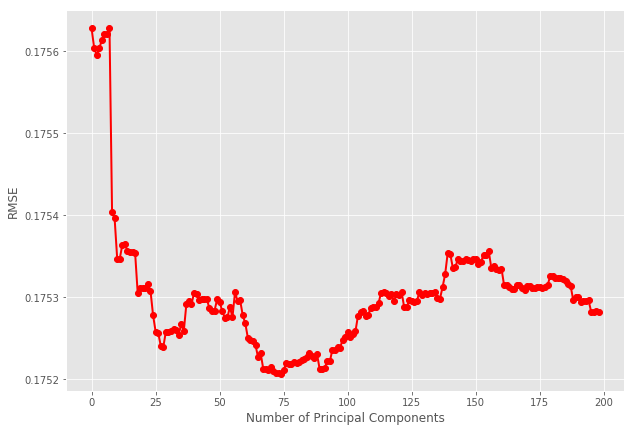

In [113]:
fig = plt.figure(figsize=(10,7))
plt.plot(error, 'ro-', linewidth=2)
# plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('RMSE')
# leg = plt.legend([''], loc='best', borderpad=0.3, 
#                  shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
#                  markerscale=0.4)
leg.get_frame().set_alpha(0.4)
leg.draggable(state=True)
plt.show()
fig.savefig('ols1.png')

In [7]:
trainX, testX, trainy, testy = train_test_split(X_pca[:,:75], y, test_size=0.2, random_state = 1)

reg = LinearRegression(n_jobs=-1)
reg.fit(trainX, trainy); print('fit...')
predy = reg.predict(testX)
print(RMSE(testy, predy))


fit...
0.175207260039


In [8]:
reg.score

<bound method RegressorMixin.score of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)>

In [85]:
eigvals = pca.explained_variance_ratio_[0:10]

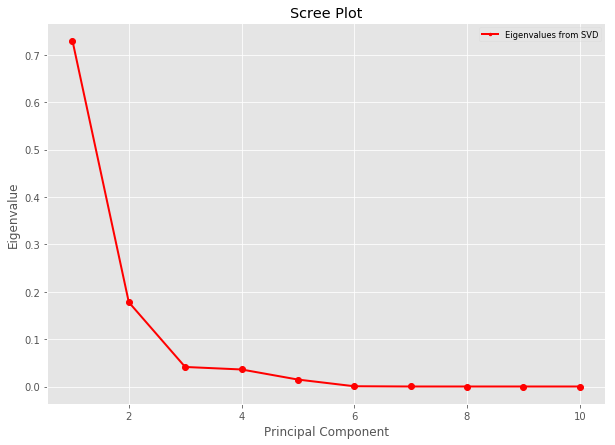

In [114]:
fig = plt.figure(figsize=(10,7))
plt.plot(list(range(1,11)), eigvals, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
#I don't like the default legend so I typically make mine like below, e.g.
#with smaller fonts and a bit transparent so I do not cover up data, and make
#it moveable by the viewer in case upper-right is a bad place for it 
leg = plt.legend(['Eigenvalues from SVD'], loc='best', borderpad=0.3, 
                 shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
leg.draggable(state=True)
plt.show()
fig.savefig('ols2.png')

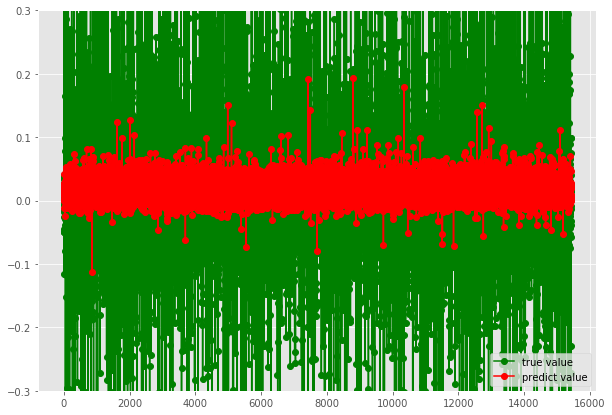

In [115]:
fig2 = plt.figure(figsize=(10,7))
plt.plot(np.arange(len(predy)), testy,'go-',label='true value')
plt.plot(np.arange(len(predy)), predy,'ro-',label='predict value')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()
fig.savefig('ols3.png')